In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path

from stringart.preprocessing.image import BaseImage, create_mask, apply_mask, create_anchors
from stringart.preprocessing.importancemaps import open_importance_maps, outline_importance_map, combine_importance_maps, background_importance_map
from stringart.core.stringimage import StringArtImage
from stringart.preprocessing.linedicts import make_line_dict
from stringart.algorithm.execute import create_string_art
from stringart.utils.io import save_string_art, load_string_art, save_instructions
from stringart.algorithm.costmethod import CostMethod

from stringart.algorithm.gpu.exec_gpu import create_string_art_gpu


In [27]:
def display_images(image_list):
    if not isinstance(image_list, list):
        image_list = [image_list]  # Make sure image_list is a list for consistent processing

    num_images = len(image_list)
    
    # Adjust for single image case
    if num_images == 1:
        fig, axes = plt.subplots(figsize=(10, 10))
        axes = [axes]  # Make axes a list for consistent processing
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))
    
    for ax, img in zip(axes, image_list):
        ax.imshow(img.T, cmap="gray_r")
        ax.axis('off')  # Turn off axis numbers and ticks
    
    plt.tight_layout()
    plt.show()

In [28]:
def display_importance(importance_map):
    plt.figure(figsize=(5,5))
    plt.imshow(importance_map.T, cmap='RdBu_r')
    plt.colorbar()
    plt.show()

In [29]:
base_img = BaseImage(path="./data/tom.jpg", resize_to=1400)
mask = create_mask(base_img.img)
base_img.img = apply_mask(base_img.img, mask)
anchors = create_anchors(img=base_img.img, num_anchors=288)

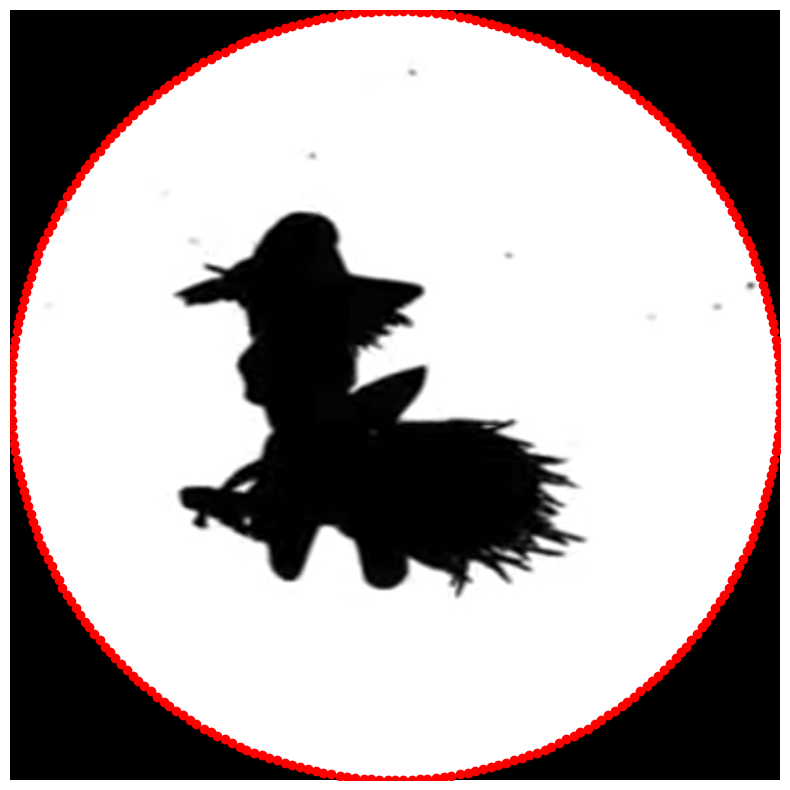

In [31]:
plt.figure(figsize=(10, 10))  
plt.imshow(base_img.img.T, cmap='gray_r')
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [32]:
string_art_img = StringArtImage(base_image=base_img, anchors=anchors, line_darkness=0.2, mask=mask)

In [33]:
importance_maps = open_importance_maps(folder_path="./data/importance_maps/tom/", string_art_img_shape=string_art_img.img.shape)

In [34]:
outline_importance_maps = []
for map in importance_maps:
    outline_map = outline_importance_map(importance_map=map, edge_thickness=3)
    outline_importance_maps.append(outline_map)

In [35]:
background_map = background_importance_map(importance_map=importance_maps[2], cutoff=0.1)

In [36]:
for map in importance_maps:
    map.img *= 2
for map in outline_importance_maps:
    map.img *= 4

background_map.img *= (-1)

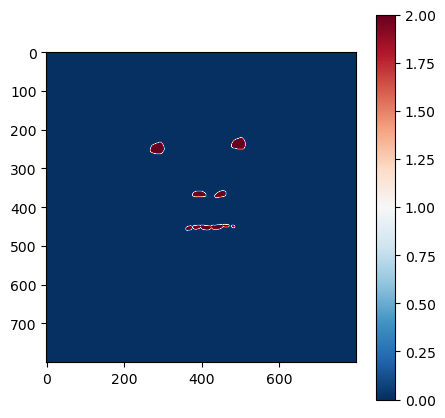

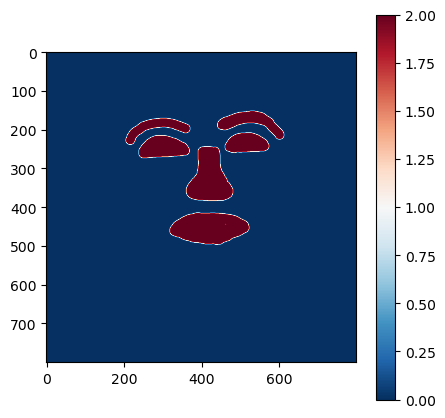

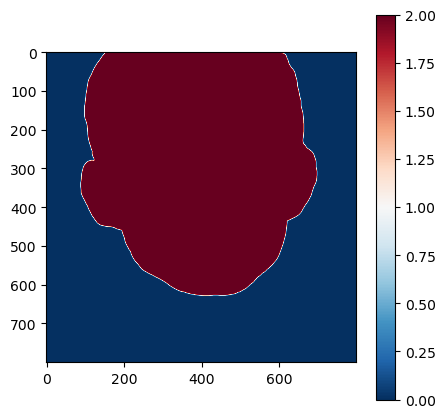

In [37]:
for map in importance_maps:
    display_importance(importance_map=map.img)

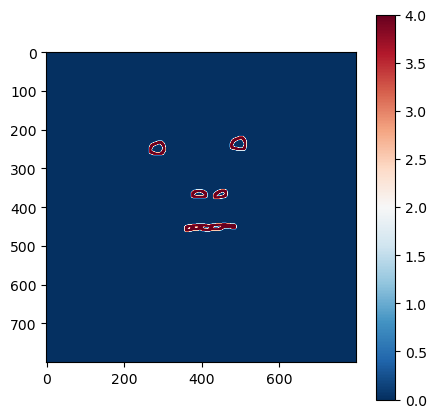

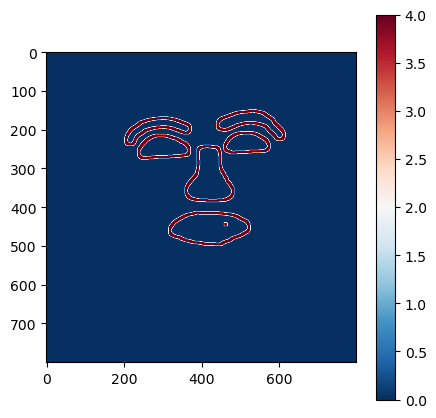

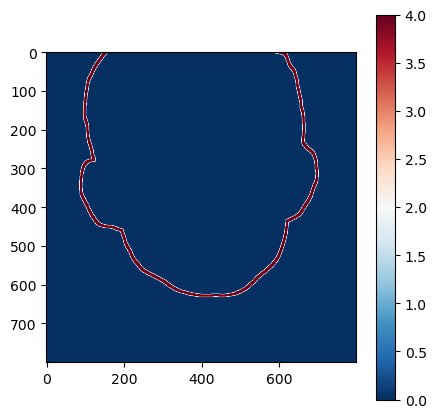

In [38]:
for map in outline_importance_maps:
    display_importance(map.img)

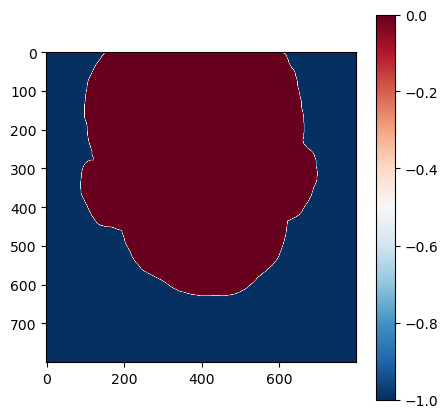

In [39]:
display_importance(background_map.img)

In [40]:
all_importance_maps = importance_maps + outline_importance_maps + [background_map]
main_importance_map = combine_importance_maps(all_importance_maps)
main_importance_map.apply_gaussian_blur(35)
main_importance_map.apply_dynamic_sigmoid(exponent=1, std_exponent=1)

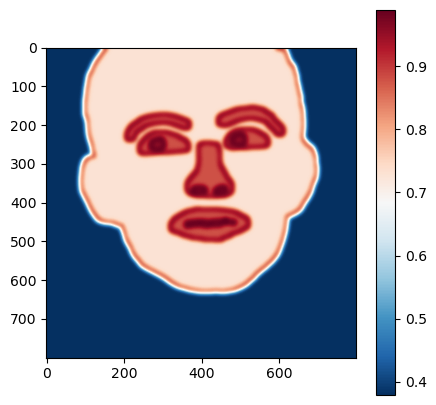

In [41]:
display_importance(main_importance_map.img)

In [42]:
line_pixel_dict, line_darkness_dict = make_line_dict(
    data_folder="./data",
    string_art_img=string_art_img,
    closest_neighbors=10,
)

Creating new line dictionary


Creating Lines: 100%|██████████| 300/300 [00:32<00:00,  9.15it/s]


Saving new line dictionary
Done!


In [ ]:
final_img_gpu = create_string_art_gpu(
    first_anchor=0,
    base_img=base_img.img,
    string_art_img=string_art_img,
    line_pixel_dict=line_pixel_dict,
    line_darkness_dict=line_darkness_dict,
    iterations=5,
    cost_method=CostMethod.MEAN,
    max_darkness=1,
    importance_map=main_importance_map
)

In [43]:
final_img = create_string_art(
    first_anchor=0,
    base_img=base_img,
    string_art_img=string_art_img,
    line_pixel_dict=line_pixel_dict,
    line_darkness_dict=line_darkness_dict,
    iterations=2000,
    cost_method=CostMethod.MEAN,
    max_darkness=1
    #importance_map=main_importance_map
)

Building line arrays
Done!


100%|██████████| 2000/2000 [00:26<00:00, 74.67it/s]


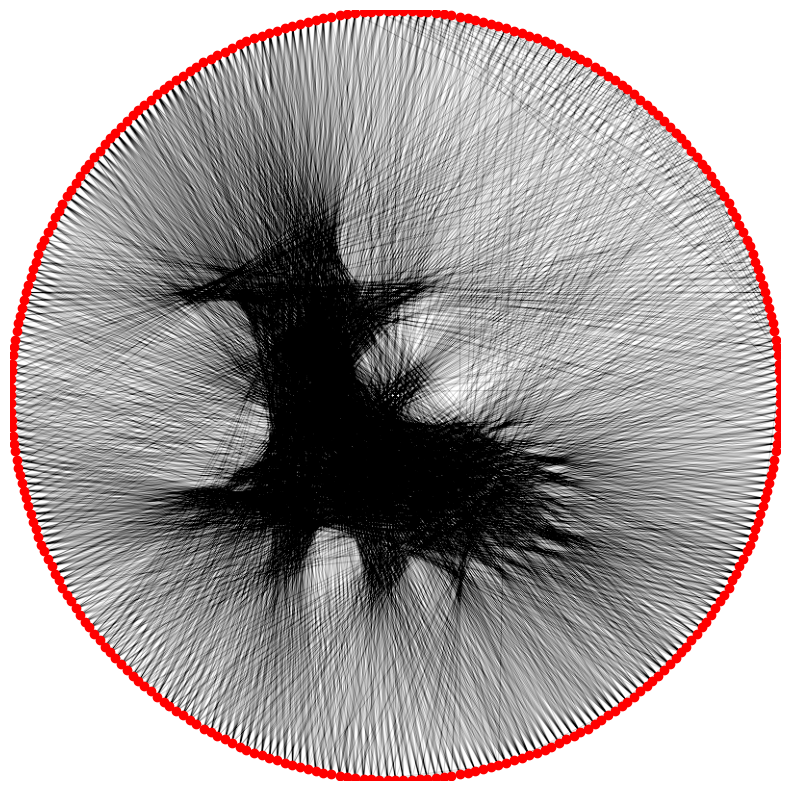

In [44]:
plt.figure(figsize=(10, 10))  
plt.imshow(final_img.img.T, cmap='gray_r', vmin=0, vmax=1)
anchors_x = [anchor.coordinates[0] for anchor in anchors]
anchors_y = [anchor.coordinates[1] for anchor in anchors]
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

In [ ]:
save_string_art(string_art_img=final_img, directory="./outputs/MSE")

In [ ]:
final_img: StringArtImage = load_string_art("./outputs/MSE")

In [ ]:
print(final_img.string_path)

[(287, 181), (182, 193), (194, 210), (209, 198), (197, 210), (211, 193), (194, 181), (180, 195), (196, 179), (178, 197), (196, 218), (217, 197), (198, 177), (176, 200), (201, 216), (215, 202), (201, 223), (224, 200), (199, 225), (224, 213), (212, 191), (190, 213), (212, 225), (226, 198), (199, 177), (178, 190), (191, 219), (218, 192), (193, 217), (216, 198), (197, 185), (186, 213), (214, 203), (202, 176), (177, 201), (202, 222), (221, 190), (191, 177), (178, 198), (197, 179), (178, 207), (208, 226), (225, 195), (196, 224), (225, 210), (209, 176), (175, 203), (204, 221), (220, 191), (190, 179), (180, 196), (197, 227), (226, 194), (195, 181), (180, 206), (207, 176), (175, 210), (209, 177), (178, 200), (199, 223), (222, 189), (188, 223), (222, 211), (212, 175), (176, 201), (200, 217), (218, 185), (184, 195), (196, 220), (221, 195), (194, 225), (226, 202), (203, 177), (176, 211), (212, 174), (175, 204), (205, 220), (219, 206), (205, 174), (173, 213), (212, 178), (179, 199), (198, 183), (18

In [ ]:
save_instructions(string_path=final_img.string_path, path="./outputs/MSE/file.txt")